In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from pprint import pprint


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.cuda.empty_cache()

cuda


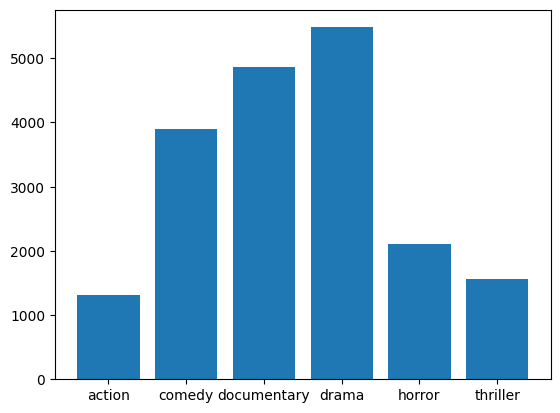

In [3]:
# Part 1.a
genres = ["action", "comedy", "documentary", "drama", "horror", "thriller"]
genres_count = {
    "action": 0,
    "comedy": 0,
    "documentary": 0,
    "drama": 0,
    "horror": 0,
    "thriller": 0
}
label_map = {
    "action": 0,
    "comedy": 1,
    "documentary": 2,
    "drama": 3,
    "horror": 4,
    "thriller": 5
}
genre_map = {
    0: "action",
    1: "comedy",
    2: "documentary",
    3: "drama",
    4: "horror",
    5: "thriller"
}
labels = []

train_df = pd.read_csv('data/train.csv', header=0)

labels_df = train_df['genre']

for _, genre in labels_df.items():
    genres_count[genre] += 1
    labels.append(label_map[genre])


plt.bar(genres, genres_count.values())

# weights of each class (for random dataloader later)
weights = []
for count in genres_count.values():
    weights.append((1 - count/len(labels_df))**2.5)

weights[5] += 0.005
weights[0] += 0.005

# validation labels
validation_genres_count = {
    "action": 0,
    "comedy": 0,
    "documentary": 0,
    "drama": 0,
    "horror": 0,
    "thriller": 0
}
validation_labels = []

validation_df = pd.read_csv('data/validate.csv', header=0)

validation_labels_df = validation_df['genre']

for _, genre in validation_labels_df.items():
    validation_genres_count[genre] += 1
    validation_labels.append(label_map[genre])

# test data
test_df = pd.read_csv('data/test.csv', header=0, index_col=0)


### Part a writeup
As seen in the plot above, there is a clear imbalance in the data. There are a lot more instances of comedy,
documentary and drama movie types compared to the others

In [4]:
# 1.b
train_df = pd.read_csv('data/train.csv', header=0)

feature_tensor = torch.tensor(train_df.drop(columns=['genre']).values, dtype=torch.double, device=device)
label_tensor = torch.tensor(labels, dtype=torch.long, device=device)

dataset = TensorDataset(feature_tensor, label_tensor)
sample_weights = torch.tensor(weights, device=device)[label_tensor]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True)

dataloader = DataLoader(dataset, 64, sampler=weighted_sampler)

v_feature_tensor = torch.tensor(validation_df.drop(columns=['genre']).values, dtype=torch.double, device=device)
v_label_tensor = torch.tensor(validation_labels, dtype=torch.long, device=device)

t_feature_tensor = torch.tensor(test_df.values, dtype=torch.double, device=device)


### Part b writeup
For the dataloader, I used the built-in Dataloader from Pytorch. The batch size was set to 64 
to allow for faster training. For the sampling, I used a weighted random sampler from Pytorch. 
The weight of each datapoint was calculated by taking the inverse of the total count of the datapoint's
label divided by the total count of all datapoints, all to the power of 3 (ie, for datapoint with label "action", it's weight 
is (1 - (# of datapoints with label "action)/(# of total datapoints)))^3. The reason for the power of 3.5 is to emphasize the difference between the weights of the majority and minority classes (the value of 3 was fount to work the best through trial and error) This random sampling accounts for the uneven distribution of data by putting more weight onto the datapoints with labels that are less present in the dataset. 

*Note, the weights are calculated in the code of part a*

In [65]:
# 1.c
class SimpleNeuralNet(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super().__init__()
        layers = []

        prev_size = 300
        for _ in range(num_layers):
            layers.append(nn.Linear(prev_size, num_nodes, dtype=torch.float64))
            layers.append(nn.ReLU())
            prev_size = num_nodes

        layers.append(nn.Linear(prev_size, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits
    
    def custom_train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_error = 0
            running_sum = 0
            for inputs, label in dataloader:
                output = self(inputs)
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_error += torch.count_nonzero(torch.abs(torch.argmax(output, -1) - label))
                running_sum += len(inputs)

            
            # report train and validation loss
            validation_output = self(v_feature_tensor)
            train_error_list.append((running_error/running_sum).cpu())
            validation_error_list.append((torch.count_nonzero(torch.abs(torch.argmax(validation_output, -1) - v_label_tensor))/len(v_feature_tensor)).cpu())
            print(f"EPOCH {i}")
            print(f"Training error: {train_error_list[-1]}")
            print(f"Validation error: {validation_error_list[-1]}")
        
        return train_error_list, validation_error_list  


### Part c writeup
The model is designed to take a number of hidden layers and a number of nodes per hidden layer. Each hidden layer is paired with a ReLU activation function for non-linearities. The model will train for a specified number of epochs, outputting the training and validation accuracy at each epoch.

In [58]:
def get_stats(model, num_epoch):
        
    train_error_list, validation_error_list = model.custom_train(dataloader, 0.001, num_epoch, v_feature_tensor, v_label_tensor)
    epoch_list = [i for i in range(1, num_epoch + 1)]
    plt.figure(1)
    plt.title("Model training error")
    plt.xlabel("Epoch")
    plt.ylabel("Error rate")
    plt.plot(epoch_list, train_error_list)

    plt.figure(2)
    plt.title("Model validation error")
    plt.xlabel("Epoch")
    plt.ylabel("Error rate")
    plt.plot(epoch_list, validation_error_list)

    model.eval()

    # accuracy, class-wise and f1 score
    class_accuracy_count = [0] * 6
    accuracy_count = 0
    confusion_matrix = [[0] * 6 for i in range(6)] # row is actual, col is predicted
    class_accuracy_score = []

    for i in range(len(v_feature_tensor)):
        feature = v_feature_tensor[i]
        label = v_label_tensor[i]

        prediction = model(feature)

        if torch.argmax(prediction, 0) == label:
            accuracy_count += 1
            class_accuracy_count[label] += 1

        confusion_matrix[label][torch.argmax(prediction, 0)] += 1

    for class_i in range(6):
        class_accuracy_score.append({
            "TP": 0,
            "TN": 0,
            "FP": 0,
            "FN": 0,
            "AC_rate": 0,
            "F1": 0
        })

        class_accuracy_score[class_i]["TP"] = confusion_matrix[class_i][class_i]

        for row in range(6):
            for col in range(6):
                if row == class_i and col != class_i:
                    class_accuracy_score[class_i]["FN"] += confusion_matrix[row][col]
                if col == class_i and row != class_i:
                    class_accuracy_score[class_i]["FP"] += confusion_matrix[row][col]
                if row != class_i and col != class_i:
                    class_accuracy_score[class_i]["TN"] += confusion_matrix[row][col]

        class_accuracy_score[class_i]["AC_rate"] = class_accuracy_count[class_i] / validation_genres_count[genre_map[class_i]]

        r = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) != 0 else 0
        p = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) != 0 else 0
        class_accuracy_score[class_i]["F1"] = 2*((p*r)/(p+r)) if (p+r) != 0 else 0

    print(class_accuracy_score)
        


EPOCH 0
Training error: 0.750156044960022
Validation error: 0.604010283946991
EPOCH 1
Training error: 0.6667186617851257
Validation error: 0.5483227372169495
EPOCH 2
Training error: 0.6233873963356018
Validation error: 0.5106908679008484
EPOCH 3
Training error: 0.5926966071128845
Validation error: 0.4720136821269989
EPOCH 4
Training error: 0.5678839087486267
Validation error: 0.49881213903427124
EPOCH 5
Training error: 0.545984148979187
Validation error: 0.4653615951538086
EPOCH 6
Training error: 0.5062422156333923
Validation error: 0.45006176829338074
EPOCH 7
Training error: 0.4836142361164093
Validation error: 0.425829142332077
EPOCH 8
Training error: 0.4762796461582184
Validation error: 0.40739333629608154
EPOCH 9
Training error: 0.4710257947444916
Validation error: 0.41223984956741333
EPOCH 10
Training error: 0.4617665410041809
Validation error: 0.42839494347572327
EPOCH 11
Training error: 0.4646795690059662
Validation error: 0.40121638774871826
EPOCH 12
Training error: 0.450946718

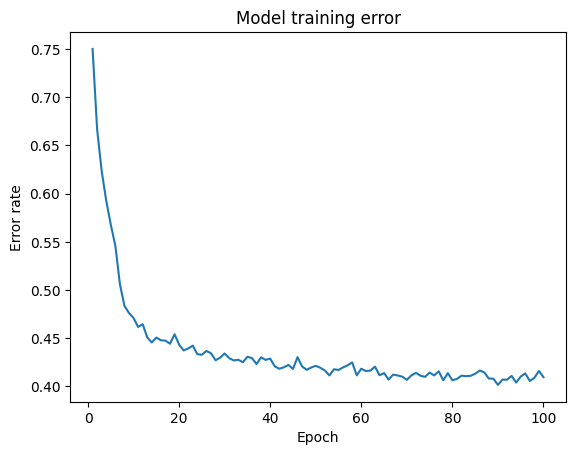

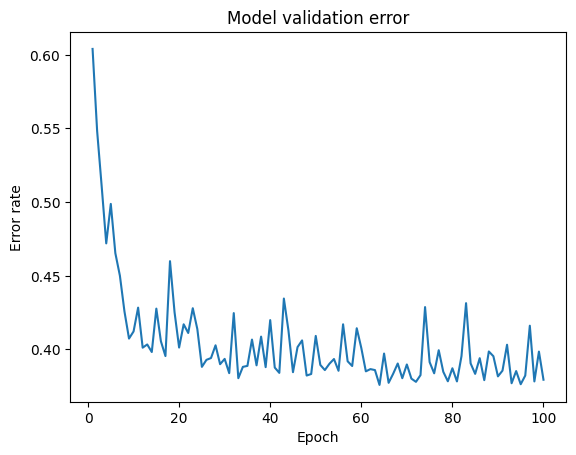

In [79]:
# 1.3 part i)
model = SimpleNeuralNet(1, 64)

model = model.to(device)
    
get_stats(model, 100)


### Part c.i writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 0 | 1432 | 2259 | 1920 | 919 | 0 |
| TN | 9866 | 7323 | 7049 | 6144 | 8512 | 9728 |
| FP | 0 | 959 | 758 | 1367 | 909 | 0 |
| FN | 657 | 809 | 457 | 1092 | 183 | 795 |
| F1 | 0 | 0.62 | 0.79 | 0.61 | 0.63 | 0 |
| Accuracy | 0 | 0.6 | 0.83 | 0.6 | 0.83 | 0 |

Overall Training Accuracy: 0.59

Overall Validation Accuracy: 0.62


EPOCH 0
Training error: 0.7873491048812866
Validation error: 0.7135797739028931
EPOCH 1
Training error: 0.7198293805122375
Validation error: 0.6939085721969604
EPOCH 2
Training error: 0.6415418386459351
Validation error: 0.5060344338417053
EPOCH 3
Training error: 0.6152205467224121
Validation error: 0.5356837511062622
EPOCH 4
Training error: 0.5826570987701416
Validation error: 0.49349045753479004
EPOCH 5
Training error: 0.5781314969062805
Validation error: 0.5135417580604553
EPOCH 6
Training error: 0.5631502270698547
Validation error: 0.4973866939544678
EPOCH 7
Training error: 0.5417186617851257
Validation error: 0.4786657989025116
EPOCH 8
Training error: 0.5411984920501709
Validation error: 0.47191867232322693
EPOCH 9
Training error: 0.5163337588310242
Validation error: 0.45937472581863403
EPOCH 10
Training error: 0.5152413249015808
Validation error: 0.45376795530319214
EPOCH 11
Training error: 0.5117561221122742
Validation error: 0.4491114914417267
EPOCH 12
Training error: 0.5029129

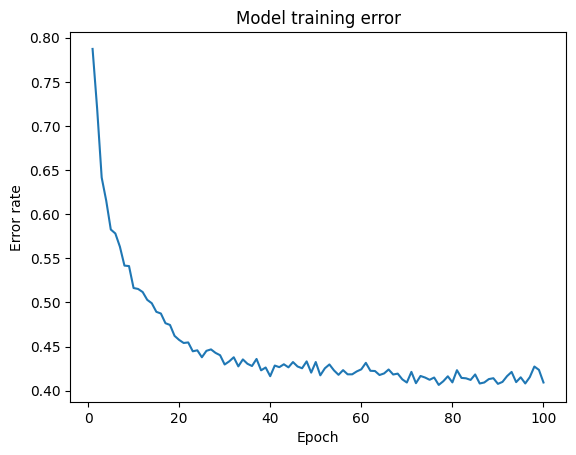

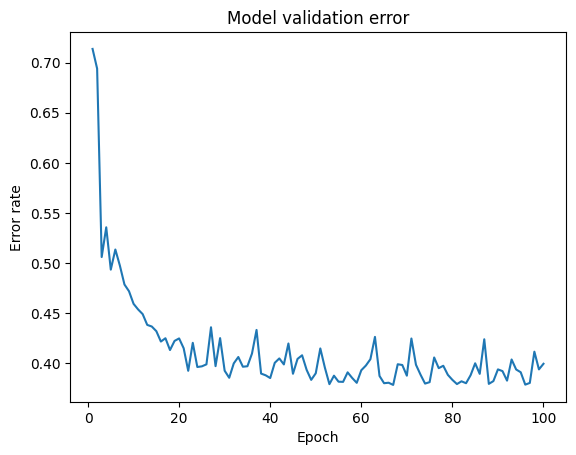

In [80]:
model = SimpleNeuralNet(2, 32)

model = model.to(device)
    
get_stats(model, 100)

### part c.ii writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 6 | 1000 | 2029 | 2335 | 948 | 0 |
| TN | 9843 | 7840 | 7344 | 5314 | 8341 | 9728 |
| FP | 23 | 442 | 463 | 2197 | 1080 | 0 |
| FN | 651 | 1241 | 687 | 677 | 154 | 795 |
| F1 | 0.02 | 0.54 | 0.78 | 0.62 | 0.61 | 0 |
| Accuracy | 0.01 | 0.45 | 0.75 | 0.78 |  0.86 | 0 |

Overall Training Accuracy: 0.59

Overall Validation Accuracy: 0.60

EPOCH 0
Training error: 0.7708073258399963
Validation error: 0.7611898183822632
EPOCH 1
Training error: 0.6793591380119324
Validation error: 0.6093319654464722
EPOCH 2
Training error: 0.627600908279419
Validation error: 0.5392948985099792
EPOCH 3
Training error: 0.5957657098770142
Validation error: 0.5207640528678894
EPOCH 4
Training error: 0.5522783994674683
Validation error: 0.45585861802101135
EPOCH 5
Training error: 0.5280898809432983
Validation error: 0.47904589772224426
EPOCH 6
Training error: 0.5191947221755981
Validation error: 0.45804429054260254
EPOCH 7
Training error: 0.5209633708000183
Validation error: 0.43723273277282715
EPOCH 8
Training error: 0.4936537444591522
Validation error: 0.4206025004386902
EPOCH 9
Training error: 0.4790886342525482
Validation error: 0.41670626401901245
EPOCH 10
Training error: 0.46483561396598816
Validation error: 0.40226173400878906
EPOCH 11
Training error: 0.46707239747047424
Validation error: 0.4650765061378479
EPOCH 12
Training error: 0.4582

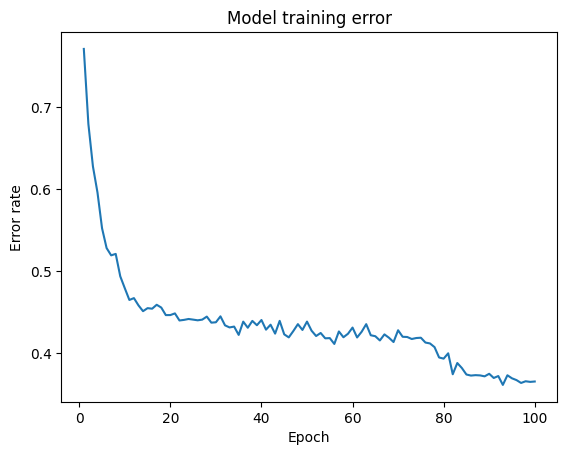

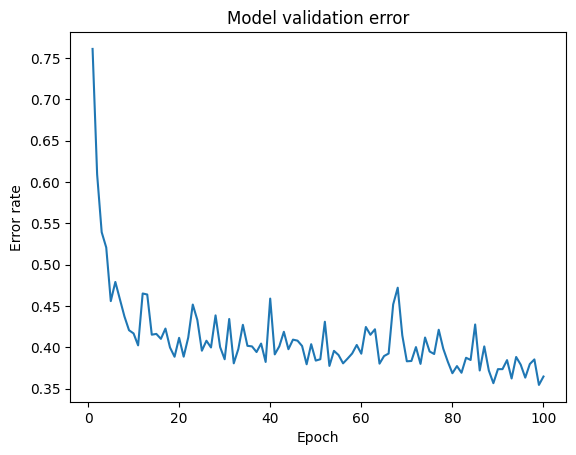

In [101]:
model = SimpleNeuralNet(2, 64)

model = model.to(device)
    
get_stats(model, 100)

### part c.iii writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 285 | 1424 | 1966 | 2105 | 898 | 0 |
| TN | 9659 | 7316 | 7436 | 5907 | 8724 | 9728 |
| FP | 207 | 966 | 371 | 1604 | 697 | 0 |
| FN | 372 | 817 | 750 | 907 | 204 | 795 |
| F1 | 0.50 | 0.61 | 0.79 | 0.63 | 0.67 | 0 |
| Accuracy | 0.43 | 0.64 | 0.72 | 0.70 | 0.81 | 0 |

Overall Training Accuracy: 0.64

Overall Validation Accuracy: 0.64

### part c comparison
The performance of all 3 model architectues are roughly the same, but with the 2 layer, 64 nodes model having the highest test and validation accuracy. This is expected as it has the highest layer and node count of the 3 models, which allows it to capture more about the complex relationship of the input data. Furthermore, even with the weighted sampling, the model with 1 layer and 64 nodes has an accuracy of 0 for the genres of "action" and "thriller". This again changes as the number of layers and nodes increases. The model with the highest number of layers and nodes (iii) has the highest accuracy and F1 scores averaged accross all classes.

In [5]:
# 1.d
class GoodNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_size = 256
        self.num_layers = 2

        self.rnn = nn.LSTM(300, self.hidden_size, self.num_layers, batch_first=True, dtype=torch.float64)


        layers = []

        layers.append(nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5, dtype=torch.float64))
        layers.append(nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, dtype=torch.float64))
        layers.append(nn.MaxPool1d(kernel_size=5))
        layers.append(nn.Dropout(p=0.5))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(3712, 6, dtype=torch.float64))
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):

        logits = self.stack(x)
        return logits
    
    def custom_train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_sum = 0
            running_error = 0
            for inputs, label in dataloader:
                inputs = torch.unsqueeze(inputs, 1)
                output = self(inputs) # move channel to first dimension for conv
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_error += torch.count_nonzero(torch.abs(torch.argmax(output, -1) - label))
                running_sum += len(inputs)

            # report train and validation loss

            validation_output = self(torch.unsqueeze(v_feature_tensor, 1))
            print(validation_output.shape)
            train_error_list.append((running_error/running_sum).cpu())
            validation_error_list.append((torch.count_nonzero(torch.abs(torch.argmax(validation_output, -1) - v_label_tensor))/len(v_feature_tensor)).cpu())
            print(f"EPOCH {i}")
            print(f"Training error: {train_error_list[-1]}")
            print(f"Validation error: {validation_error_list[-1]}")
            if validation_error_list[-1] < 0.365:
                break

        
        return train_error_list, validation_error_list  

torch.Size([10523, 6])
EPOCH 0
Training error: 0.7440698742866516
Validation error: 0.6568469405174255
torch.Size([10523, 6])
EPOCH 1
Training error: 0.5775592923164368
Validation error: 0.4569989740848541
torch.Size([10523, 6])
EPOCH 2
Training error: 0.4879317283630371
Validation error: 0.4331464469432831
torch.Size([10523, 6])
EPOCH 3
Training error: 0.46228671073913574
Validation error: 0.41727644205093384
torch.Size([10523, 6])
EPOCH 4
Training error: 0.43175196647644043
Validation error: 0.40150147676467896
torch.Size([10523, 6])
EPOCH 5
Training error: 0.4071473181247711
Validation error: 0.3923785984516144
torch.Size([10523, 6])
EPOCH 6
Training error: 0.3952351212501526
Validation error: 0.39114323258399963
torch.Size([10523, 6])
EPOCH 7
Training error: 0.3900853097438812
Validation error: 0.3891475796699524
torch.Size([10523, 6])
EPOCH 8
Training error: 0.38743236660957336
Validation error: 0.39247363805770874
torch.Size([10523, 6])
EPOCH 9
Training error: 0.38353100419044495

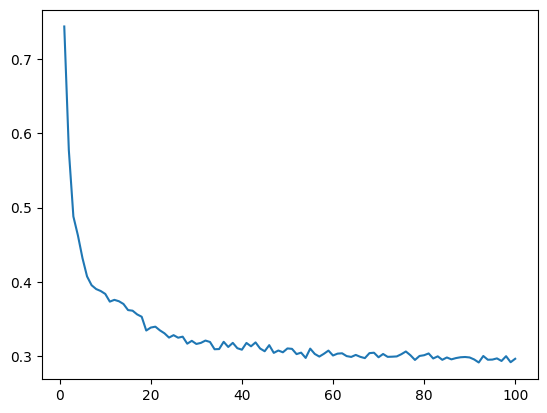

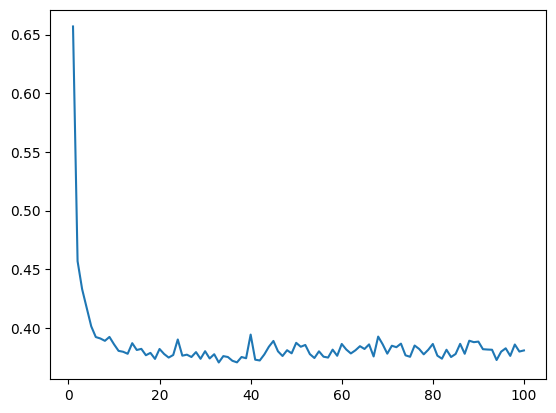

In [6]:
num_epoch = 100
model = GoodNeuralNet()

model = model.to(device)
    
train_error_list, validation_error_list = model.custom_train(dataloader, 0.0002, num_epoch, v_feature_tensor, v_label_tensor)
epoch_list = [i for i in range(1, len(train_error_list) + 1)]
plt.figure(1)
plt.plot(epoch_list, train_error_list)
plt.figure(2)
plt.plot(epoch_list, validation_error_list)

model.eval()

# accuracy, class-wise and f1 score
class_accuracy_count = [0] * 6
accuracy_count = 0
confusion_matrix = [[0] * 6 for i in range(6)] # row is actual, col is predicted
class_accuracy_score = []

for i in range(len(v_feature_tensor)):
    label = v_label_tensor[i]
    prediction = model(torch.unsqueeze(torch.unsqueeze(v_feature_tensor[i], 0), 0))
    if torch.argmax(prediction[0], 0) == label:
        accuracy_count += 1
        class_accuracy_count[label] += 1

    confusion_matrix[label][torch.argmax(prediction[0], 0)] += 1
    
for class_i in range(6):
    class_accuracy_score.append({
        "TP": 0,
        "TN": 0,
        "FP": 0,
        "FN": 0,
        "AC_rate": 0,
        "F1": 0
    })

    class_accuracy_score[class_i]["TP"] = confusion_matrix[class_i][class_i]

    for row in range(6):
        for col in range(6):
            if row == class_i and col != class_i:
                class_accuracy_score[class_i]["FN"] += confusion_matrix[row][col]
            if col == class_i and row != class_i:
                class_accuracy_score[class_i]["FP"] += confusion_matrix[row][col]
            if row != class_i and col != class_i:
                class_accuracy_score[class_i]["TN"] += confusion_matrix[row][col]

    class_accuracy_score[class_i]["AC_rate"] = class_accuracy_count[class_i] / validation_genres_count[genre_map[class_i]]

    r = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) != 0 else 0
    p = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) != 0 else 0
    class_accuracy_score[class_i]["F1"] = 2*((p*r)/(p+r)) if (p+r) != 0 else 0

print(class_accuracy_score)

### part c.iii writeup
Confusion Matrix + Accuracy + F1 scores:
|  | Action | Comedy | Documentary | Drama | Horror | Thriller |
| -- | -- | -- | -- | -- | -- | -- |
| TP | 348 | 1241 | 2231 | 1808 | 807 | 331 |
| TN | 9524 | 7676 | 7133 | 6484 | 8949 | 9092 |
| FP | 342 | 606 | 674 | 1027 | 472 | 636 |
| FN | 309 | 1000 | 485 | 1204 | 295 | 464 |
| F1 | 0.52 | 0.61 | 0.79 | 0.62 | 0.68 | 0.38 |
| Accuracy | 0.53 | 0.55 | 0.82 |  0.60 | 0.73 | 0.42 |

Overall Training Accuracy: 0.73

Overall Validation Accuracy: 0.65

### part e writeup
I decided to add Convolutional layers in order to capture any local relationships between neighbouring embeddings. I opted to not use any of layers based on Recurrent networks since the the input data is already an embedding of the entire movie description with a sequence length of 1. To capture more complex relationships, I had my model use 2 Convolutional layers followed some dropout (to help with overfitting as I realized the train accuracy was much lower than validation accuracy) and a max pooling layer. By using the max pooling layer, I hoped to capture only the important features while disregarding unimportant ones. I then flattened the output of the convolutional layer and fed the output into a fully connected layer before outputting the probability of the 6 classes. 

Other than the model itself, I also tuned some of the hyperperameters. I increased the weights for the 3 under-represented classes as I realized that the accuracy for them was still low. I also decreased the learning rate of the Adam optimizer to reduce overshooting and the fluctuation of training/validation accuracy between epochs.

The result of this improved model is higher training and validation accuracy. Furthermore, this model was finally able to classify movies of Thriller genre (no previous model was able to), proving that the convolutional layers helped with capturing more complex relationships between the embeddings

In [18]:
prediction = model(torch.unsqueeze(t_feature_tensor, 1))

prediction_index = torch.argmax(torch.squeeze(prediction, 1), -1).cpu()

prediction_index = torch.add(prediction_index, 1)
print(prediction_index)

prediction_np = prediction_index.numpy()
prediction_df = pd.DataFrame(prediction_np)
print(prediction_df)
prediction_df.to_csv("submission.csv", index=True, header=["label"])



tensor([5, 3, 3,  ..., 2, 2, 3])
       0
0      5
1      3
2      3
3      3
4      3
...   ..
10518  5
10519  2
10520  2
10521  2
10522  3

[10523 rows x 1 columns]


### 2.c
Given more time, I would have spent longer tuning the hyperperameters (learning rate, weights, etc). I would have done cross-validation to choose the best hyperparameters that maximized accuracy/reduced overfitting. Furthermore, I could have made the model to be more complex (more layers/nodes) if I had more time and resources to train the model. Additionally, I could have used the raw descriptions of the movies to create sequential embeddings. This would allow me to take more advantage of Recurrent Networks such as LSTMs and Transformers to capture important contextual information between words that gives hint to the genre of the movie. Without the restriction of this competition, I would also leverage existing NLP models such as GPT or BERT and adding a classification layer on top. 